# Постановка задачи

In [65]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
DIR_TRAIN = "../AI/archive/train/"
DIR_VALID = "../AI/archive/valid/"
DIR_TEST = "../AI/archive/test/"

In [4]:
#список файлов и директорий в папке.
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    #Проверяем наличие классов внутри папок, например ../AI/archive/train/"classname"
    train_count += len(os.listdir(DIR_TRAIN + _class))
    valid_count += len(os.listdir(DIR_VALID + _class))
    test_count += len(os.listdir(DIR_TEST + _class))

print("Total train images: ",train_count)
print("Total valid images: ",valid_count)
print("Total test images: ",test_count)

Total Classes:  260
Total train images:  36609
Total valid images:  1300
Total test images:  1300


In [5]:
#создадим списки изображений в трех выборках
train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
    
    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)
        
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

#создадим словарь класс:Id
class_to_int = {classes[i] : i for i in range(len(classes))}
class_to_int

{'BLACK-CAPPED CHICKADEE': 0,
 'GUINEAFOWL': 1,
 'RED BELLIED PITTA': 2,
 'BOBOLINK': 3,
 'CALIFORNIA GULL': 4,
 'MYNA': 5,
 'ENGGANO MYNA': 6,
 'SMITHS LONGSPUR': 7,
 'HOOPOES': 8,
 'COMMON POORWILL': 9,
 'CHIPPING SPARROW': 10,
 'HOUSE FINCH': 11,
 'SRI LANKA BLUE MAGPIE': 12,
 'STRAWBERRY FINCH': 13,
 'PARADISE TANAGER': 14,
 'CANARY': 15,
 'BLACK-NECKED GREBE': 16,
 'RUFUOS MOTMOT': 17,
 'OKINAWA RAIL': 18,
 'MALABAR HORNBILL': 19,
 'CALIFORNIA QUAIL': 20,
 'PURPLE MARTIN': 21,
 'TREE SWALLOW': 22,
 'VARIED THRUSH': 23,
 'HAWAIIAN GOOSE': 24,
 'WHITE NECKED RAVEN': 25,
 'BLACK TAIL CRAKE': 26,
 'YELLOW BELLIED FLOWERPECKER': 27,
 'RUFOUS KINGFISHER': 28,
 'CROW': 29,
 'MALEO': 30,
 'CALIFORNIA CONDOR': 31,
 'GOULDIAN FINCH': 32,
 'LARK BUNTING': 33,
 'TEAL DUCK': 34,
 'GILA WOODPECKER': 35,
 'CRESTED CARACARA': 36,
 'CAPE MAY WARBLER': 37,
 'GO AWAY BIRD': 38,
 'NORTHERN GANNET': 39,
 'SPANGLED COTINGA': 40,
 'COMMON STARLING': 41,
 'PELICAN': 42,
 'BROWN NOODY': 43,
 'ROADRUNNER':

In [6]:
train_dataset = ImageFolder(root = DIR_TRAIN, transform = T.ToTensor())
valid_dataset = ImageFolder(root = DIR_VALID, transform = T.ToTensor())
test_dataset = ImageFolder(root = DIR_TEST, transform = T.ToTensor())
#перетасовка данных что-бы не возникало последовательности от обучения на одном классе
train_random_sampler = RandomSampler(train_dataset)
valid_random_sampler = RandomSampler(valid_dataset)
test_random_sampler = RandomSampler(test_dataset)

#Внунтри DataLoader есть параметр shuffle - который мы можем не указывать,
#мы уже юзали Randomsampler
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,# сколько образцов в партии загружаются, дефолт - 1
    # стратегия извлечения данных, если shuffle - true указывать нельзя
    sampler = train_random_sampler,
    #сколько подпроцессов использовать для загрузки данных
    num_workers = 4,
)

valid_data_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 16,
    sampler = valid_random_sampler,
    num_workers = 4,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    sampler = test_random_sampler,
    num_workers = 4,
)

In [70]:
train_data_loader.dataset

Dataset ImageFolder
    Number of datapoints: 36609
    Root location: ../AI/archive/train/
    StandardTransform
Transform: ToTensor()

tensor([149,  83,  48, 192,  63, 121,  21,  23,   5, 207, 120, 230,  11, 258,
        229, 206])
tensor(149)
(tensor([[[0.4588, 0.4510, 0.4431,  ..., 0.2471, 0.2588, 0.2314],
         [0.4745, 0.4784, 0.4824,  ..., 0.2431, 0.2353, 0.2353],
         [0.4902, 0.4824, 0.4902,  ..., 0.2549, 0.2314, 0.2510],
         ...,
         [0.5490, 0.5451, 0.5412,  ..., 0.5451, 0.6000, 0.5922],
         [0.5608, 0.5451, 0.5373,  ..., 0.5686, 0.6039, 0.5765],
         [0.5529, 0.5490, 0.5529,  ..., 0.5961, 0.6157, 0.5765]],

        [[0.3098, 0.3098, 0.3137,  ..., 0.1294, 0.1451, 0.1176],
         [0.3333, 0.3412, 0.3529,  ..., 0.1255, 0.1176, 0.1216],
         [0.3529, 0.3451, 0.3608,  ..., 0.1294, 0.1020, 0.1216],
         ...,
         [0.3765, 0.3725, 0.3686,  ..., 0.3804, 0.4314, 0.4235],
         [0.3882, 0.3725, 0.3647,  ..., 0.4039, 0.4392, 0.4118],
         [0.3804, 0.3765, 0.3804,  ..., 0.4314, 0.4510, 0.4118]],

        [[0.2275, 0.2078, 0.1922,  ..., 0.0902, 0.1137, 0.0863],
         [0.2

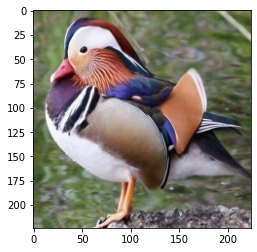

In [69]:
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
plt.imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
print(labels)
label = labels[0]
print(label)
print(train_data_loader.dataset[label])

In [60]:
ds = train_data_loader.dataset
ds

Dataset ImageFolder
    Number of datapoints: 36609
    Root location: ../AI/archive/train/
    StandardTransform
Transform: ToTensor()

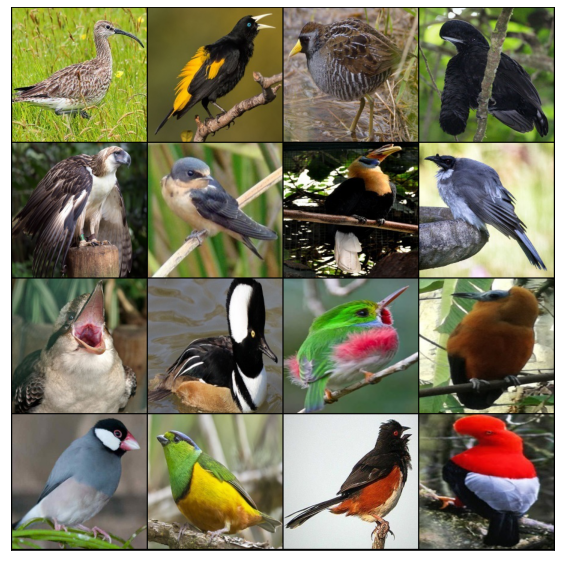

In [35]:
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [57]:
model.

AttributeError: 'VGG' object has no attribute 'predict'